In [0]:
items = [1, 2, 3, 4, 5]
squared = list(map(lambda x: x**3, items))
squared

[1, 8, 27, 64, 125]

In [0]:
# https://neurowhai.tistory.com/292

In [0]:
from tensorflow.python.client import device_lib
import tensorflow as tf
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3876883829019089860, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5933003659533636849
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12620358854082576940
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11978132078730237417
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from keras import layers, models
from __future__ import print_function
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Dropout, Embedding
import numpy as np
from keras import datasets
from keras import backend as K
from keras.utils import plot_model
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt


batch_size = 16  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/dataset.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
# 전처리
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


# 문자 -> 숫자 변환용 사전
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# 학습에 사용할 데이터를 담을 3차원 배열
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# 문장을 문자 단위로 원 핫 인코딩하면서 학습용 데이터를 만듬
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# 숫자 -> 문자 변환용 사전
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

def RepeatVectorLayer(rep, axis):
  return layers.Lambda(lambda x: K.repeat_elements(K.expand_dims(x, axis), rep, axis),
                      lambda x: tuple((x[0],) + x[1:axis] + (rep,) + x[axis:]))


# 인코더 생성
encoder_inputs = layers.Input(shape=(max_encoder_seq_length, num_encoder_tokens))
# dropout 전
#encoder = layers.GRU(latent_dim, return_sequences=True, return_state=True)
encoder = layers.GRU(latent_dim,dropout=0.25,recurrent_dropout=0.25, return_sequences=True, return_state=True)
encoder_outputs, state_h = encoder(encoder_inputs)


# 디코더 생성
decoder_inputs = layers.Input(shape=(max_decoder_seq_length, num_decoder_tokens))
# dropout 전
#decoder = layers.GRU(latent_dim, return_sequences=True, return_state=True)
decoder = layers.GRU(latent_dim,dropout=0.25,recurrent_dropout=0.25, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder(decoder_inputs, initial_state=state_h)

# embedding test




# attention 생성
'''
어텐션의 기본 아이디어는 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 
인코더에서의 전체 입력 문장을 다시 한 번 참고한다는 점입니다. 
단, 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, 
해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 
집중(attention)해서 보게 됩니다.
'''

repeat_d_layer = RepeatVectorLayer(max_encoder_seq_length, 2)
# 입력을 n 번 반복합니다.
repeat_d = repeat_d_layer(decoder_outputs)

repeat_e_layer = RepeatVectorLayer(max_decoder_seq_length, 1)
# 입력을 n 번 반복합니다.
repeat_e = repeat_e_layer(encoder_outputs)

concat_for_score_layer = layers.Concatenate(axis=-1)
#layers.Concatenate는 입력 목록을 연결하는 계층입니다.
# 연결 축을 제외하고 모두 동일한 모양의 텐서 목록을 입력으로 사용하고 
# 모든 입력의 연결 인 단일 텐서를 반환합니다.
concat_for_score = concat_for_score_layer([repeat_d, repeat_e])

dense1_t_score_layer = layers.Dense(latent_dim // 2, activation='tanh')
# Dense 클래스 객체를 TimeDistributed wrapper를 사용하여 3차원 텐서 입력을 받을 수 있게 확장
dense1_score_layer = layers.TimeDistributed(dense1_t_score_layer)
dense1_score = dense1_score_layer(concat_for_score)


dense2_t_score_layer = layers.Dense(1)
# Dense 클래스 객체를 TimeDistributed wrapper를 사용하여 3차원 텐서 입력을 받을 수 있게 확장
dense2_score_layer = layers.TimeDistributed(dense2_t_score_layer)
dense2_score = dense2_score_layer(dense1_score)
dense2_score = layers.Reshape((max_decoder_seq_length, max_encoder_seq_length))(dense2_score)

# soft max 설정
softmax_score_layer = layers.Softmax(axis=-1)
softmax_score = softmax_score_layer(dense2_score)

# 입력을 n 번 반복합니다 RepeatVectorLayer
repeat_score_layer = RepeatVectorLayer(latent_dim, 2)
repeat_score = repeat_score_layer(softmax_score)

# layers.Permute 주어진 패턴에 따라 입력 치수를 변경합니다.
permute_e = layers.Permute((2, 1))(encoder_outputs)
repeat_e_layer = RepeatVectorLayer(max_decoder_seq_length, 1)
repeat_e = repeat_e_layer(permute_e)

attended_mat_layer = layers.Multiply() # 행렬곱
attended_mat = attended_mat_layer([repeat_score, repeat_e])

context_layer = layers.Lambda(lambda x: K.sum(x, axis=-1),
                             lambda x: tuple(x[:-1]))
context = context_layer(attended_mat)

concat_context_layer = layers.Concatenate(axis=-1)
'''입력 목록을 연결하는 계층입니다.
연결 축을 제외하고 모두 동일한 모양의 텐서 목록을 입력으로 
사용하고 모든 입력의 연결 인 단일 텐서를 반환합니다.'''
concat_context = concat_context_layer([context, decoder_outputs])

attention_dense_output_layer = layers.Dense(latent_dim, activation='tanh')
attention_output_layer = layers.TimeDistributed(attention_dense_output_layer)
attention_output = attention_output_layer(concat_context)

decoder_dense = layers.Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(attention_output)


# 모델 생성
model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

che = 'total.h5'
point = ModelCheckpoint(filepath=che , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=100)
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    verbose=1,callbacks=[point,early_stopping])
# Save model
model_json = model.to_json()
with open("model_dropX.json", "w") as json_file : 
    json_file.write(model_json)
model.save_weights("wh_re_drop.h5")
#model.save('atten_GRU_weight2.h5')
# 


# Next: inference mode (sampling).
# Here's the drill:
# 1) 입력을 인코딩하고 초기 디코더 상태 검색
# 2) 이 초기 상태로 디코더 한 단계 실행
# "시퀀스 시작" 토큰을 대상으로 한다.
# 출력이 다음 대상 토큰임
# 3) 현재 대상 토큰 및 현재 상태로 반복

# 샘플링 모델 정의
encoder_model = models.Model(encoder_inputs, [encoder_outputs, state_h])
encoder_outputs_input = layers.Input(shape=(max_encoder_seq_length, latent_dim))

decoder_inputs = layers.Input(shape=(1, num_decoder_tokens))
decoder_state_input_h = layers.Input(shape=(latent_dim,))
decoder_outputs, decoder_h = decoder(decoder_inputs, initial_state=decoder_state_input_h)

repeat_d_layer = RepeatVectorLayer(max_encoder_seq_length, 2)
repeat_d = repeat_d_layer(decoder_outputs)

repeat_e_layer = RepeatVectorLayer(1, axis=1)
repeat_e = repeat_e_layer(encoder_outputs_input)

concat_for_score_layer = layers.Concatenate(axis=-1)
concat_for_score = concat_for_score_layer([repeat_d, repeat_e])

dense1_score_layer = layers.TimeDistributed(dense1_t_score_layer)
dense1_score = dense1_score_layer(concat_for_score)

dense2_score_layer = layers.TimeDistributed(dense2_t_score_layer)
dense2_score = dense2_score_layer(dense1_score)
dense2_score = layers.Reshape((1, max_encoder_seq_length))(dense2_score)

softmax_score_layer = layers.Softmax(axis=-1)
softmax_score = softmax_score_layer(dense2_score)

repeat_score_layer = RepeatVectorLayer(latent_dim, 2)
repeat_score = repeat_score_layer(softmax_score)

permute_e = layers.Permute((2, 1))(encoder_outputs_input)
repeat_e_layer = RepeatVectorLayer(1, axis=1)
repeat_e = repeat_e_layer(permute_e)

attended_mat_layer = layers.Multiply()
attended_mat = attended_mat_layer([repeat_score, repeat_e])

context_layer = layers.Lambda(lambda x: K.sum(x, axis=-1),
                             lambda x: tuple(x[:-1]))
context = context_layer(attended_mat)

concat_context_layer = layers.Concatenate(axis=-1)
concat_context = concat_context_layer([context, decoder_outputs])

attention_output_layer = layers.TimeDistributed(attention_dense_output_layer)
attention_output = attention_output_layer(concat_context)

decoder_att_outputs = decoder_dense(attention_output)

decoder_model = models.Model([decoder_inputs, decoder_state_input_h, encoder_outputs_input],
                            [decoder_outputs, decoder_h, decoder_att_outputs])

def decode_sequence(input_seq):
  # 입력 문장을 인코딩
  enc_outputs, states_value = encoder_model.predict(input_seq)
 
  # 디코더의 입력으로 쓸 단일 문자
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  # 첫 입력은 시작 문자인 '\t'로 설정
  target_seq[0, 0, target_token_index['\t']] = 1.
 
  # 문장 생성
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    # 이전의 출력, 상태를 디코더에 넣어서 새로운 출력, 상태를 얻음
    # 이전 문자와 상태로 다음 문자와 상태를 얻는다고 보면 됨.
    dec_outputs, h, output_tokens = decoder_model.predict(
        [target_seq, states_value, enc_outputs])
 
    # 사전을 사용해서 원 핫 인코딩 출력을 실제 문자로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]
    decoded_sentence += sampled_char
 
    # 종료 문자가 나왔거나 문장 길이가 한계를 넘으면 종료
    if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
      stop_condition = True
 
    # 디코더의 다음 입력으로 쓸 데이터 갱신
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.
    
    states_value = h
 
  return decoded_sentence

for seq_index in range(30):
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('"{}" -> "{}"'.format(input_texts[seq_index], decoded_sentence.strip()))

Using TensorFlow backend.


Number of samples: 1175
Number of unique input tokens: 780
Number of unique output tokens: 719
Max sequence length for inputs: 165
Max sequence length for outputs: 183




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 165, 780)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 183, 719)     0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, 165, 256), ( 796416      input_1[0][0]                    
_

In [0]:
result = []
for seq_index in range(1,len(input_texts),1):
  
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  #print('"{}" -> "{}"'.format(input_texts[seq_index], decoded_sentence.strip()))
  result.append(decoded_sentence.strip())

target_texts2 = []

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    _, target_text2 = line.split('\t')
    target_text2 = target_text2
    target_texts2.append(target_text2)
    # for char in target_text2:
    #     if char not in target_characters:
    #         target_characters.add(char)
tar = target_texts2[1:len(input_texts)]

In [0]:
def dap(result, tar):
  import nltk.translate.bleu_score as bleu
  candidate = []
  references = []
  dap = []
  dd = []
  for i in range(0,len(result)):
    re = []
    candidate = result[i]
    re.append(tar[i])
    dap.append(bleu.sentence_bleu(list(map(lambda ref: ref.split(), re)),candidate.split()))
    if i % 10 == 0:
      dd.append(bleu.sentence_bleu(list(map(lambda ref: ref.split(), re)),candidate.split()))
      #print("예측값:",candidate,'//',"실제값:",re,"Bleu 점수:",dd)
      dd=[]
  return sum(dap)/len(result)
# 성능테스트
print('전체점수 : ', dap(result,tar))

전체점수 :  0.7839549046126238


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


# 검증

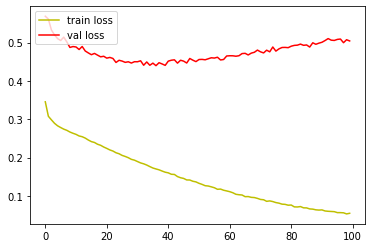

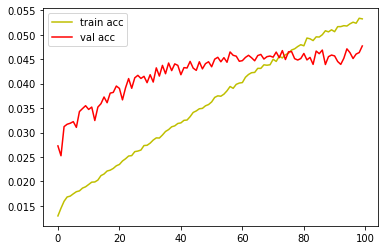

In [0]:
# 손실 그래프
plt.plot(history.history['loss'], 'y', label='train loss')
plt.plot(history.history['val_loss'], 'r', label='val loss')
plt.legend(loc='upper left')
plt.show()


# 정확도 그래프
# plt.plot(history.history['acc'], 'y', label='train acc')
# plt.plot(history.history['val_acc'], 'r', label='val acc')
# plt.legend(loc='upper left')
# plt.show()

모델불러오고 시작